In [1]:
import sys
import os
import cv2
import time
import numpy as np
import ffmpeg
import matplotlib.pyplot as plt
from pathlib import Path
from torchvision.transforms import ToPILImage

In [2]:
if os.name == 'nt':
    repo_path = Path(".").absolute().parent
    data_path = Path("D:/Datas/") / "lanevideo"
else:    
    repo_path = Path(".").absolute().parent
    data_path = repo_path.parent / "data" / "lanevideo"
    
sys.path.append(str(repo_path))

---

* References: https://medium.com/@mithi/advanced-lane-finding-using-computer-vision-techniques-7f3230b6c6f2

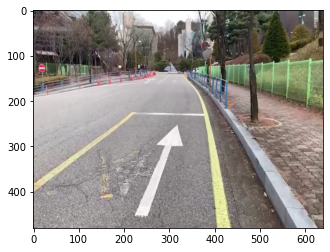

In [189]:
from lanedetection.helpers import imreader, imsaver
img_path = "./imgs/test.png"
# img_path = "./imgs/straight_lines.jpg"
image = imreader(img_path)
height, width = 480, 640

def resize_image(img, width, height):
    return cv2.resize(img, (width, height))

def draw(img1, img2, tit1, tit2, cmap1=None, cmap2="gray"):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    ax1, ax2 = axes
    ax1.imshow(img1, cmap=cmap1)
    ax1.set_title(tit1)
    ax1.set_axis_off()

    ax2.imshow(img2, cmap=cmap2)
    ax2.set_title(tit2)
    ax2.set_axis_off()
    plt.tight_layout()
    plt.show()

img = resize_image(image, width, height)
plt.imshow(img)
plt.show()

1. Camera calibration

In [131]:
from lanedetection import ChessBoard

# Let's initialize 20 chessboards, note that at instatiation, 
# it finds all chessboard corners and object points
chessboards = []

for n in range(20):
    this_path = f"./camera_cal/calibration{n+1}.jpg"
    chessboard = ChessBoard(i = n, path = this_path, nx = 9, ny = 6)
    chessboards.append(chessboard)

# We use these corners and object points (and image dimensions) 
# from all chessboards to estimate the calibration parameters 
points, corners, shape = [], [], chessboards[0].dimensions

for chessboard in chessboards:    
    if chessboard.has_corners: 
        points.append(chessboard.object_points)
        corners.append(chessboard.corners)

r, matrix, distortion_coef, rv, tv = cv2.calibrateCamera(points, corners, shape, None, None)

# Let's store these parameters somewhere so we can use them later
calibration_data = { "camera_matrix": matrix, "distortion_coefficient": distortion_coef }


In [132]:
import pickle

pickle.dump(calibration_data, open( "calibration_data.p", "wb" ))

2. perspective transformation

In [133]:
from lanedetection import BirdsEye, LaneFilter, Curves, show_images, save_image, roi

In [173]:
calibration_data = pickle.load(open("calibration_data.p", "rb" ))

matrix = calibration_data['camera_matrix']
dist_coef = calibration_data['distortion_coefficient']

# src_ratio = [(0.43, 0.64), (0.12, 1.0), (0.87, 1.0), (0.55, 0.64)]
# dest_ratio = [(0.25, 0.0), (0.25, 1.0), (0.75, 1.0), (0.75, 0.0)]

src_ratio = [(0.26, 0.45), (0.0, 0.65), (0.67, 1.0), (0.60, 0.45)]
dest_ratio = [(0.25, 0.0), (0.25, 1.0), (0.75, 1.0), (0.75, 0.0)]

def get_points(ratios, width, height):
    apply_ratio = lambda x, w, h: (int(w*x[0]), int(h*x[1]))
    return [apply_ratio(ratio, w=width, h=height) for ratio in ratios]

source_points = get_points(src_ratio, width, height)
dest_points = get_points(dest_ratio, width, height)

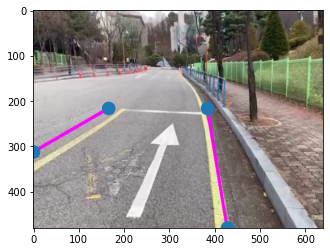

In [174]:
birdsEye = BirdsEye(source_points, dest_points, matrix, dist_coef)
undistorted_img = birdsEye.undistort(img, show_dotted=True)

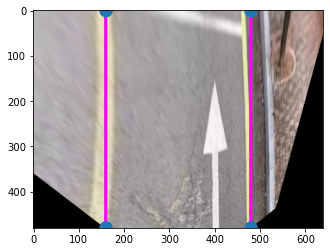

In [175]:
bird_img = birdsEye.sky_view(undistorted_img, show_dotted = True)

In [200]:
p = { 'sat_thresh': 120, 'light_thresh': 40, 'light_thresh_agr': 205,
      'grad_thresh': (0.7, 1.4), 'mag_thresh': 40, 'x_thresh': 20 }

birdsEye = BirdsEye(source_points, dest_points, matrix, dist_coef)
laneFilter = LaneFilter(p)
curves = Curves(number_of_windows = 9, margin = 100, minimum_pixels = 50, 
                ym_per_pix = 30 / 720 , xm_per_pix = 3.7 / 700)

To estimate the curvature of a road, we don’t need all the information from all the pixels of a road image. The road lane lines from the video stream are yellow and white so we can mask everything out except the yellows and whites of the image. As an added precaution, because we might see some yellow and while lines that are not lanes, or there might be lanes which are not that distinctly yellow and white, we use what is called a **Sobel operator**. A Sobel operator essentially measures the rate of change in value (and its direction) between two locations of the image. This is also technically called as the derivative or gradient. More on this later.

| HSL formatted color| |
|---|---|
| <img src="./imgs/HSL.png" width="100%">| <img src="./imgs/HSL2.png" width="100%">|



The **Hue** value is its perceived color number representation based on combinations of red, green and blue. The **Saturation** value is the measure of how colorful or or how dull it is. **Lightness** is how closer to white the color is. The yellow lanes are nicely singled out by a combination of lightness and saturation above a certain value. The white lanes are singled out by having a really high lightness value regardless of the saturation and hue.

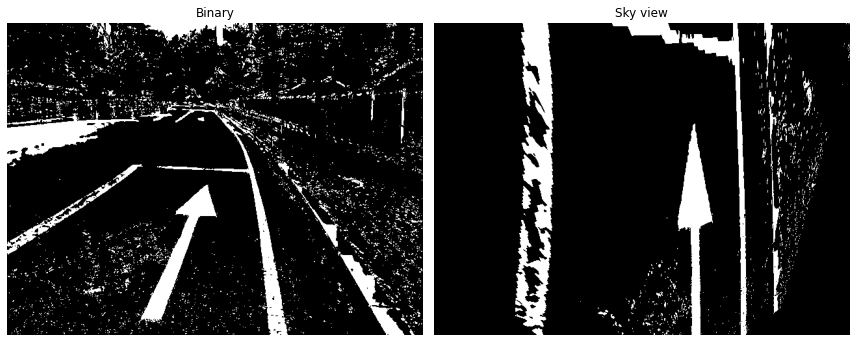

In [191]:
binary = laneFilter.apply(undistorted_img)
wb = np.logical_and(birdsEye.sky_view(binary), roi(binary)).astype(np.uint8)

draw(binary, wb, "Binary", "Sky view", cmap1="gray", cmap2="gray")

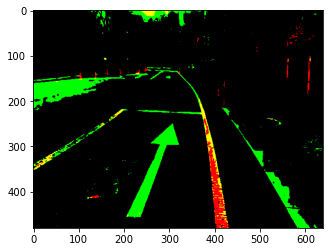

In [198]:
color_img = laneFilter.color_breakdown(undistorted_img)
plt.imshow(color_img)
plt.show()

I applied the Sobel operator to the lightness value of the image. We used a combination of thresholding the gradient of the horizontal component, the magnitude of the gradient, and the direction of the gradient. I want to weed out locations of gradient that don’t have a large enough change in lightness. Thresholding the magnitude of the gradient as well as the x component of the gradient does a good job with that. I also only consider gradients of a particular orientation. A little above 0 degrees (or about 0.7 in radians), and below 90 degrees (or about 1.4 in radians). Zero implies horizontal lines and ninety implies vertical lines, and our lanes (in vehicle view) are in between them.

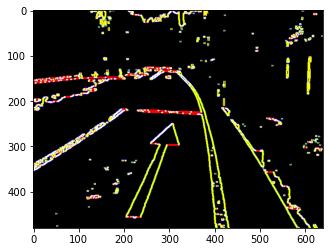

In [199]:
sobel_img = laneFilter.sobel_breakdown(color_img)
plt.imshow(sobel_img)
plt.show()

In [201]:
ground_img = birdsEye.undistort(img)
binary = laneFilter.apply(ground_img)
wb = np.logical_and(birdsEye.sky_view(binary), roi(binary)).astype(np.uint8)
result = curves.fit(wb)

ground_img_with_projection = birdsEye.project(ground_img, binary, 
                                            result['pixel_left_best_fit_curve'], 
                                            result['pixel_right_best_fit_curve'])

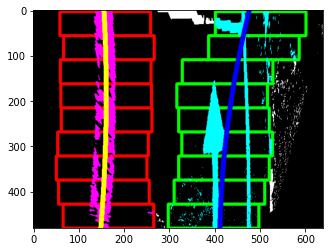

In [204]:
plt.imshow(result["image"])